# Gender and Age Prediction using Adience

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

SEED = 1

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Adience

Eran Eidinger, Roee Enbar, Tal Hassner. Age and Gender Estimation of Unfiltered Faces. Transactions on Information Forensics and Security (IEEE-TIFS), special issue on Facial Biometrics in the Wild, Volume 9, Issue 12, pages 2170 - 2179, 2014.

Citation:
[E. Eidinger, R. Enbar, and T. Hassner, Age and Gender Estimation of Unfiltered Faces, submitted to the Transactions on Information Forensics and Security, special issue on Face Recognition in the Wild ]

Adience dataset: https://talhassner.github.io/home/projects/Adience/Adience-data.html#agegender 

In [3]:
# Encoding by Gil Levi and Tal Hassner on Adience
# https://github.com/GilLevi/AgeGenderDeepLearning/blob/master/DataPreparationCode/create_train_val_txt_files.py

age_list = ['(0, 2)','(4, 6)','(8, 12)','(15, 20)','(25, 32)','(38, 43)','(48, 53)','(60, 100)']
gender_list = ['m','f']

In [4]:
AGE_CLASSES = len(age_list)
GENDER_CLASSES = len(gender_list)
fold_list = [0, 1, 2, 3, 4]

# Segmentation of Adience

In [5]:
# Segmentation of Adience by Gil Levi and Tal Hassner
# txt files for train, validation and test set taken from 
# https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold

adience_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\aligned_adience\\'

def load_data(fold_num):
    fold_dir = 'C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\train_val_txt_files_per_fold\\test_fold_is_{}\\'.format(fold_num)
    if GENDER == True:
        gender_train=pd.read_csv(fold_dir+'gender_train.txt', dtype=str, sep=' ', header=None)
        gender_train = gender_train.replace({'0':'1', '1':'0'})
        gender_val=pd.read_csv(fold_dir+'gender_val.txt', dtype=str, sep=' ', header=None)
        gender_val = gender_val.replace({'0':'1', '1':'0'})
        gender_fulltrain=pd.concat([gender_train, gender_val], ignore_index=True)
        gender_test=pd.read_csv(fold_dir+'gender_test.txt', dtype=str, sep=' ', header=None)
        gender_test = gender_test.replace({'0':'1', '1':'0'})
        return gender_train, gender_val, gender_fulltrain, gender_test
    else:
        age_train=pd.read_csv(fold_dir+'age_train.txt', dtype=str, sep=' ', header=None)
        age_val=pd.read_csv(fold_dir+'age_val.txt', dtype=str, sep=' ', header=None)
        age_fulltrain=pd.concat([age_train, age_val], ignore_index=True)
        age_test=pd.read_csv(fold_dir+'age_test.txt', dtype=str, sep=' ', header=None)
        return age_train, age_val, age_fulltrain, age_test

In [6]:
# Check 
GENDER = True
gender_train, gender_val, gender_fulltrain, gender_test = load_data(fold_list[0])
GENDER = False
age_train, age_val, age_fulltrain, age_test = load_data(fold_list[0])

display(gender_fulltrain.head())
display(gender_fulltrain.shape)
display(age_fulltrain.head())
display(age_fulltrain.shape)

,0,1
0,10069023@N00/landmark_aligned_face.1924.103359...,1
1,114841417@N06/landmark_aligned_face.489.120774...,0
2,7464014@N04/landmark_aligned_face.961.10109081...,0
3,28754132@N06/landmark_aligned_face.608.1154649...,0
4,10543088@N02/landmark_aligned_face.662.1004478...,0


(13595, 2)

,0,1
0,10069023@N00/landmark_aligned_face.1924.103359...,5
1,7464014@N04/landmark_aligned_face.961.10109081...,4
2,28754132@N06/landmark_aligned_face.608.1154649...,2
3,10543088@N02/landmark_aligned_face.662.1004478...,3
4,66870968@N06/landmark_aligned_face.1227.113262...,4


(13107, 2)

(816, 816, 3)
(167, 133, 96)


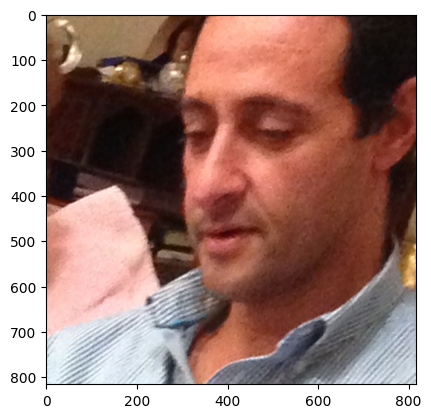

In [7]:
# Check
img = Image.open(adience_dir + gender_fulltrain[0][0])
pix = img.load()
print(np.asarray(img, dtype=np.uint8).shape) # displays dimension of image
print(pix[0,0]) # get the RGBA Value of the a pixel of an image
plt.imshow(img) # displays image

In [8]:
# (816, 816, 3)
INITIAL_HEIGHT = np.asarray(img, dtype=np.uint8).shape[0]
INITIAL_WIDTH = np.asarray(img, dtype=np.uint8).shape[1]

# Preprocess 

In [9]:
RESIZE_HEIGHT = 256
RESIZE_WIDTH = 256
CROP_HEIGHT = 227
CROP_WIDTH = 227
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
BATCH_SIZE = 64

In [10]:
def adience_ds(train, val, fulltrain, test):
    
    train_filepaths = train[0].values
    valid_filepaths = val[0].values
    fulltrain_filepaths = fulltrain[0].values
    test_filepaths = test[0].values

    train_labels = train[1].values
    valid_labels = val[1].values
    fulltrain_labels = fulltrain[1].values
    test_labels = test[1].values
    
    if GENDER == True: NUM_CLASSES = GENDER_CLASSES
    else: NUM_CLASSES = AGE_CLASSES
        
    ds_train = tf.data.Dataset.from_tensor_slices((train_filepaths, tf.one_hot(train_labels, depth=NUM_CLASSES)))
    ds_val = tf.data.Dataset.from_tensor_slices((valid_filepaths, tf.one_hot(valid_labels, depth=NUM_CLASSES)))
    ds_fulltrain = tf.data.Dataset.from_tensor_slices((fulltrain_filepaths, tf.one_hot(fulltrain_labels, depth=NUM_CLASSES)))
    ds_test = tf.data.Dataset.from_tensor_slices((test_filepaths, tf.one_hot(test_labels, depth=NUM_CLASSES)))

    return ds_train, ds_val, ds_fulltrain, ds_test

def read_image(image_file, label):
    
    mode = 1 if GRAYSCALE == True else 3
    
    image = tf.io.read_file(adience_dir+image_file)
    image = tf.image.decode_image(image, channels=mode, dtype=tf.float32, expand_animations = False) # Number of color channels for the decoded image.
    #image = image/255.0 # No need as rescale has been automatically done 
    
    # Resize image to (256, 256)
    resized_image = tf.image.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
    
    return resized_image, label

def read_image_valtest(image_file, label):
    
    mode = 1 if GRAYSCALE == True else 3
    
    image = tf.io.read_file(adience_dir+image_file)
    image = tf.image.decode_image(image, channels=mode, dtype=tf.float32, expand_animations = False) # Number of color channels for the decoded image.
    #image = image/255.0 # No need as rescale has been automatically done 
    
    # Resize image to (256, 256)
    resized_image = tf.image.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
    
    # Centercrop image to (227, 227)
    cropped_image = tf.image.crop_to_bounding_box(resized_image, (RESIZE_HEIGHT - CROP_HEIGHT) // 2, (RESIZE_WIDTH - CROP_WIDTH) // 2, CROP_HEIGHT, CROP_WIDTH) 
    
    # Resize image to (128, 128)
    resized_image = tf.image.resize(cropped_image, (INPUT_HEIGHT, INPUT_WIDTH))
    
    return resized_image, label

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(CROP_HEIGHT, CROP_WIDTH),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0, 1)),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH)
])

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

Min and max pixel values: 0.023529414 0.9997549
(256, 256, 1)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


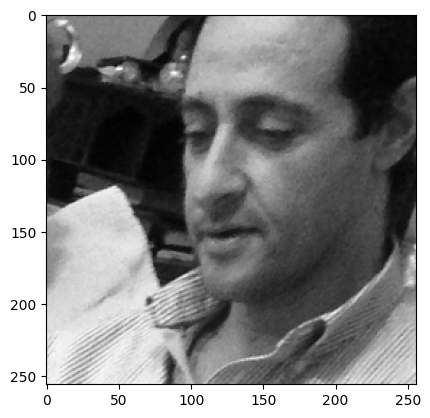

In [13]:
# Check
# Before data augmentation
GRAYSCALE = True
checkimg, checklabel = read_image(gender_fulltrain[0][0], tf.one_hot(0, depth=GENDER_CLASSES))
print("Min and max pixel values:", checkimg.numpy().min(), checkimg.numpy().max())
print(checkimg.shape)
print(checklabel)
plt.imshow(checkimg, cmap = 'gray')

Min and max pixel values: 0.030031942 0.9519856
(128, 128, 1)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


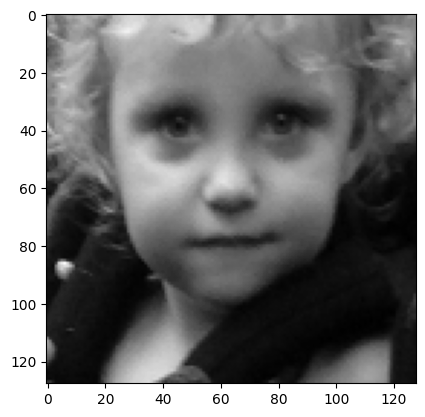

In [14]:
# Check
GRAYSCALE = True
checkimg, checklabel = read_image_valtest(gender_test[0][0], tf.one_hot(1, depth=GENDER_CLASSES))
print("Min and max pixel values:", checkimg.numpy().min(), checkimg.numpy().max())
print(checkimg.shape)
print(checklabel)
plt.imshow(checkimg, cmap = 'gray')

In [15]:
# Check
GENDER = True
gender_ds_train, gender_ds_val, gender_ds_fulltrain, gender_ds_test = adience_ds(gender_train, gender_val, gender_fulltrain, gender_test)

GRAYSCALE = True
gender_ds_fulltrain = gender_ds_fulltrain.map(read_image)
gender_ds_fulltrain = prepare(gender_ds_fulltrain, shuffle=True, augment=True)
gender_ds_test = gender_ds_test.map(read_image_valtest).batch(BATCH_SIZE)

In [16]:
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
    
import logging
tf.get_logger().setLevel(logging.ERROR)

# Pretrained Model 

In [17]:
GS_INPUT = (INPUT_HEIGHT, INPUT_WIDTH, 1)
RGB_INPUT = (INPUT_HEIGHT, INPUT_WIDTH, 3)

In [18]:
# Github source code for tf.keras.applications.resnet
#https://github.com/keras-team/keras/blob/v2.10.0/keras/applications/resnet.py#L499-L533

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from keras_applications.imagenet_utils import _obtain_input_shape

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A residual block.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer.
      kernel_size: default 3, kernel size of the bottleneck layer.
      stride: default 1, stride of the first layer.
      conv_shortcut: default True, use convolution shortcut if True,
          otherwise identity shortcut.
      name: string, block label.
    Returns:
      Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=stride, name=name + "_0_conv"
        )(x)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn"
        )(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.Conv2D(
        filters, kernel_size, padding="SAME", name=name + "_2_conv"
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn"
    )(x)

    x = layers.Add(name=name + "_add")([shortcut, x])
    x = layers.Activation("relu", name=name + "_out")(x)
    return x


def stack1(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    Args:
      x: input tensor.
      filters: integer, filters of the bottleneck layer in a block.
      blocks: integer, blocks in the stacked blocks.
      stride1: default 2, stride of the first layer in the first block.
      name: string, stack label.
    Returns:
      Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = block1(
            x, filters, conv_shortcut=False, name=name + "_block" + str(i)
        )
    return x

In [19]:
layers = None

def ResNet(
    stack_fn,
    preact,
    use_bias,
    model_name="resnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs
):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Args:
      stack_fn: a function that returns output tensor for the
        stacked residual blocks.
      preact: whether to use pre-activation or not
        (True for ResNetV2, False for ResNet and ResNeXt).
      use_bias: whether to use biases for convolutional layers or not
        (True for ResNet and ResNetV2, False for ResNeXt).
      model_name: string, model name.
      include_top: whether to include the fully-connected
        layer at the top of the network.
      weights: one of `None` (random initialization),
        'imagenet' (pre-training on ImageNet),
        or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
        if `include_top` is False (otherwise the input shape
        has to be `(224, 224, 3)` (with `channels_last` data format)
        or `(3, 224, 224)` (with `channels_first` data format).
        It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
        when `include_top` is `False`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
      classes: optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.
      **kwargs: For backwards compatibility only.
    Returns:
      A `keras.Model` instance.
    """
    global layers
    if "layers" in kwargs:
        layers = kwargs.pop("layers")
    else:
        layers = VersionAwareLayers()
    if kwargs:
        raise ValueError("Unknown argument(s): %s" % (kwargs,))
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    ### Input shape changed to 1 channel for grayscale images ###
    input_shape = GS_INPUT if GRAYSCALE == True else RGB_INPUT
    
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
    
    ### Not used as preprocessing is done on datasets instead ###
    ### Preprocessing layers added ###
    #x = tf.keras.layers.CenterCrop(CENTERCROP_HEIGHT, CENTERCROP_WIDTH, name="centercrop1")(img_input)
    #x = tf.keras.layers.Resizing(RESIZE_HEIGHT, RESIZE_WIDTH, name="resize1")(x)
    
    x = layers.ZeroPadding2D(padding=((3, 3)), name="conv1_pad")(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name="conv1_conv")(x)

    if not preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="conv1_bn"
        )(x)
        x = layers.Activation("relu", name="conv1_relu")(x)

    x = layers.ZeroPadding2D(padding=((1, 1)), name="pool1_pad")(x)
    x = layers.MaxPooling2D(3, strides=2, name="pool1_pool")(x)

    x = stack_fn(x)

    if preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="post_bn"
        )(x)
        x = layers.Activation("relu", name="post_relu")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = training.Model(inputs, x, name=model_name)

    # Load weights.
    ### Loading of imagenet weights removed. ###
    if weights is not None:
        model.load_weights(weights)

    return model

In [20]:
def ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    **kwargs
):
    """Instantiates the ResNet50 architecture."""

    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name="conv2")
        x = stack1(x, 128, 4, name="conv3")
        x = stack1(x, 256, 6, name="conv4")
        return stack1(x, 512, 3, name="conv5")

    return ResNet(
        stack_fn,
        False,
        True,
        "resnet50",
        include_top,
        weights,
        input_tensor,
        input_shape,
        pooling,
        classes,
        **kwargs
    )

# Gender

In [21]:
# Transfer Learning
# https://www.tensorflow.org/tutorials/images/transfer_learning#feature_extraction

GRAYSCALE = True

pretrained_model = ResNet50(
    include_top=False,
    weights=None, # Pretraining on CelebA
    input_tensor=None,
    pooling=None,
    classifier_activation="softmax"
)

gs_checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\ckpt\\gs_best"
pretrained_model.load_weights(gs_checkpoint_path)

In [22]:
image_batch, label_batch = next(iter(gender_ds_fulltrain))
feature_batch = pretrained_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 2048)


In [23]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [25]:
prediction_layer = tf.keras.layers.Dense(GENDER_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 2)


In [26]:
inputs = tf.keras.Input(shape=GS_INPUT)
x = pretrained_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

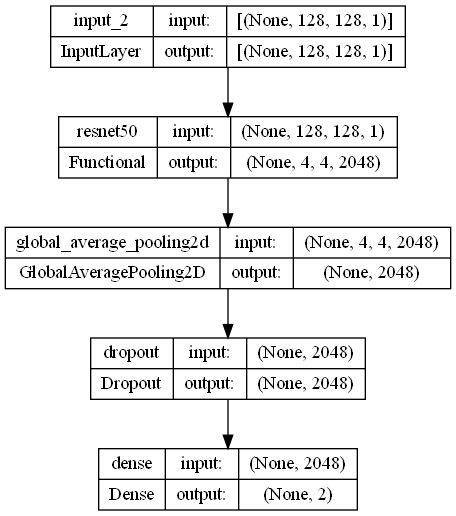

In [60]:
# Visualize our connectivity graph
# `rankdir='LR'` is to make the graph horizontal.
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, rankdir="HR")

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), 
    loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23581440  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,585,538
Trainable params: 4,098
Non-trainable params: 23,581,440
_____________________________________________

In [42]:
# 5 fold cross validation
# Feature Extraction
GENDER = True
GRAYSCALE = True

checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\featext\\featext_best"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max',
                              save_freq='epoch',
                              verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

gender_loss = []
gender_acc = []
for i in fold_list:
    
    train, val, fulltrain, test = load_data(i)
    ds_train, ds_val, ds_fulltrain, ds_test = adience_ds(train, val, fulltrain, test)
    
    ds_fulltrain = ds_fulltrain.map(read_image)
    ds_fulltrain = prepare(ds_fulltrain, shuffle=True, augment=True)
    ds_test = ds_test.map(read_image_valtest).batch(BATCH_SIZE)
    
    history = model.fit(ds_fulltrain,
                    validation_data=ds_test,
                    epochs=20,
                    callbacks=[earlystop, cp_callback],
    )
    
    # https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
    filename = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\history\\featext_{}".format(i)
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    result = model.evaluate(ds_test)
    gender_loss.append(result[0])
    gender_acc.append(result[1])

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 0.9366 - accuracy: 0.5520
Epoch 1: val_accuracy improved from -inf to 0.67008, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\tmp\featext\featext_best
213/213 [==============================] - 534s 2s/step - loss: 0.9366 - accuracy: 0.5520 - val_loss: 0.6760 - val_accuracy: 0.6701
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.6014
Epoch 2: val_accuracy did not improve from 0.67008
213/213 [==============================] - 547s 3s/step - loss: 0.7105 - accuracy: 0.6014 - val_loss: 0.6568 - val_accuracy: 0.6618
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.6168
Epoch 3: val_accuracy improved from 0.67008 to 0.69828, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\tmp\featext\featext_best
213/213 [==============================] - 505s 2s

Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.6402
Epoch 3: val_accuracy did not improve from 0.71325
221/221 [==============================] - 538s 2s/step - loss: 0.6719 - accuracy: 0.6402 - val_loss: 0.6537 - val_accuracy: 0.6803
Epoch 4/20
221/221 [==============================] - ETA: 0s - loss: 0.7267 - accuracy: 0.6389
Epoch 4: val_accuracy did not improve from 0.71325
221/221 [==============================] - 539s 2s/step - loss: 0.7267 - accuracy: 0.6389 - val_loss: 0.6998 - val_accuracy: 0.6844
Epoch 5/20
221/221 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.6485
Epoch 5: val_accuracy did not improve from 0.71325
221/221 [==============================] - 568s 3s/step - loss: 0.6835 - accuracy: 0.6485 - val_loss: 0.6451 - val_accuracy: 0.6809
Epoch 6/20
221/221 [==============================] - ETA: 0s - loss: 2.3296 - accuracy: 0.5872
Epoch 6: val_accuracy did not improve from 0.71325
221/221 [=======

In [51]:
print("Accuracy for each fold:", gender_acc)
print("Loss for each fold:", gender_loss)

Accuracy for each fold: [0.7132518291473389, 0.6790838837623596, 0.6559072136878967, 0.6714888215065002, 0.6843777298927307]
Loss for each fold: [0.6202779412269592, 1.170383334159851, 0.6835178732872009, 0.6802830100059509, 0.69981849193573]


In [52]:
print("Average accuracy across 5 folds:", sum(gender_acc) / len(gender_acc))
print("Average loss across 5 folds:", sum(gender_loss) / len(gender_loss))

Average accuracy across 5 folds: 0.6808218955993652
Average loss across 5 folds: 0.7708561301231385


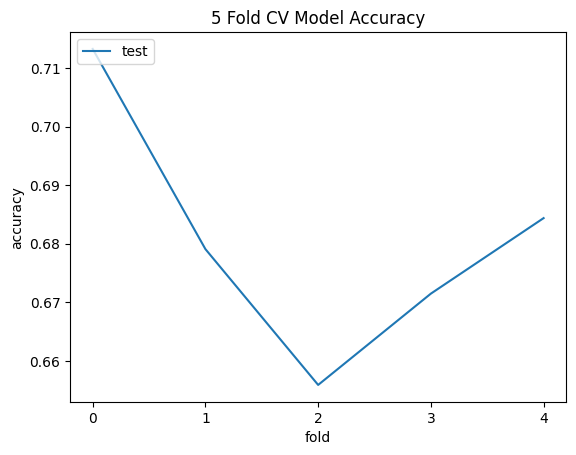

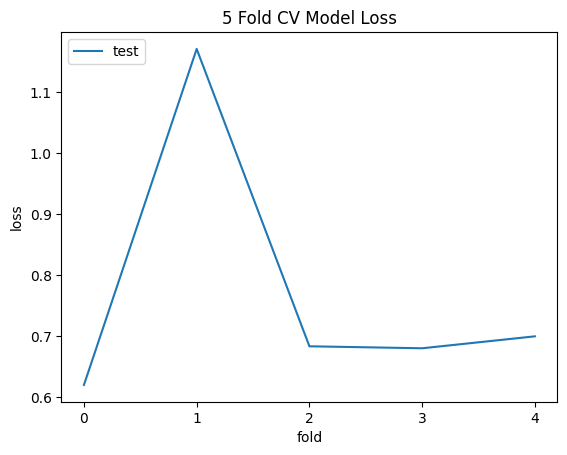

In [47]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(gender_acc)
plt.title('5 Fold CV Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

plt.figure(2)
plt.plot(gender_loss)
plt.title('5 Fold CV Model Loss')
plt.ylabel('loss')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

In [30]:
# Fine-tuning

# Load best model weights from feature extraction
checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\featext\\featext_best"
model.load_weights(checkpoint_path)

pretrained_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the pretrained model: ", len(pretrained_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the pretrained model:  175


In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), 
    loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23581440  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,585,538
Trainable params: 9,994,242
Non-trainable params: 13,591,296
_________________________________________

In [57]:
# 5 fold cross validation
# Fine-tuning
GENDER = True
GRAYSCALE = True

checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\finetune\\finetune_best"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max',
                              save_freq='epoch',
                              verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

gender_loss = []
gender_acc = []
for i in fold_list:
    
    train, val, fulltrain, test = load_data(i)
    ds_train, ds_val, ds_fulltrain, ds_test = adience_ds(train, val, fulltrain, test)
    
    ds_fulltrain = ds_fulltrain.map(read_image)
    ds_fulltrain = prepare(ds_fulltrain, shuffle=True, augment=True)
    ds_test = ds_test.map(read_image_valtest).batch(BATCH_SIZE)
    
    history = model.fit(ds_fulltrain,
                    validation_data=ds_test,
                    epochs=20,
                    callbacks=[earlystop, cp_callback],
    )
    
    # https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
    filename = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\history\\finetune_{}".format(i)
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    result = model.evaluate(ds_test)
    gender_loss.append(result[0])
    gender_acc.append(result[1])

Epoch 1/20
213/213 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.6336
Epoch 1: val_accuracy improved from -inf to 0.69104, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\tmp\finetune\finetune_best
213/213 [==============================] - 818s 4s/step - loss: 0.6834 - accuracy: 0.6336 - val_loss: 0.5944 - val_accuracy: 0.6910
Epoch 2/20
213/213 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.6488
Epoch 2: val_accuracy did not improve from 0.69104
213/213 [==============================] - 750s 3s/step - loss: 0.6975 - accuracy: 0.6488 - val_loss: 0.8569 - val_accuracy: 0.6603
Epoch 3/20
213/213 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.6553
Epoch 3: val_accuracy improved from 0.69104 to 0.72348, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\tmp\finetune\finetune_best
213/213 [==============================] - 761

Epoch 6/20
224/224 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.6780
Epoch 6: val_accuracy did not improve from 0.74045
52/52 [==============================] - 92s 2s/step - loss: 0.5735 - accuracy: 0.7254
Epoch 1/20
221/221 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.6764
Epoch 1: val_accuracy did not improve from 0.74045
221/221 [==============================] - 678s 3s/step - loss: 0.6158 - accuracy: 0.6764 - val_loss: 0.5810 - val_accuracy: 0.6985
Epoch 2/20
221/221 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.6815
Epoch 2: val_accuracy did not improve from 0.74045
221/221 [==============================] - 724s 3s/step - loss: 0.6116 - accuracy: 0.6815 - val_loss: 0.5876 - val_accuracy: 0.6899
Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.6429
Epoch 3: val_accuracy did not improve from 0.74045
221/221 [==============================] - 733s 3s/step - los

In [58]:
print("Accuracy for each fold after fine-tuning:", gender_acc)
print("Loss for each fold after fine-tuning:", gender_loss)

Accuracy for each fold after fine-tuning: [0.7404541969299316, 0.7395143508911133, 0.6737699508666992, 0.7254369854927063, 0.6985272765159607]
Loss for each fold after fine-tuning: [0.5678704380989075, 0.5831136703491211, 0.5997834801673889, 0.5735496282577515, 0.5810254216194153]


In [59]:
print("Average accuracy across 5 folds after fine-tuning:", sum(gender_acc) / len(gender_acc))
print("Average loss across 5 folds after fine-tuning:", sum(gender_loss) / len(gender_loss))

Average accuracy across 5 folds after fine-tuning: 0.7155405521392822
Average loss across 5 folds after fine-tuning: 0.5810685276985168


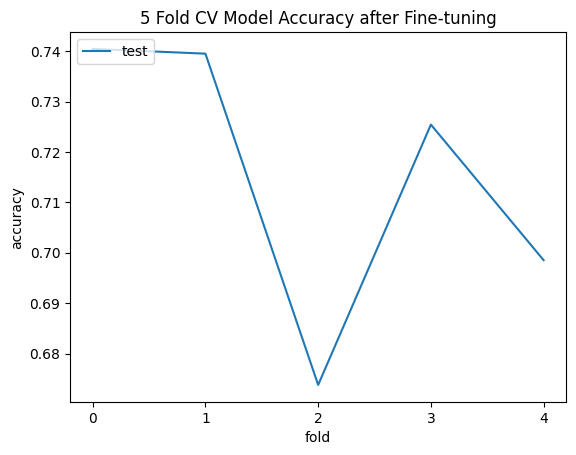

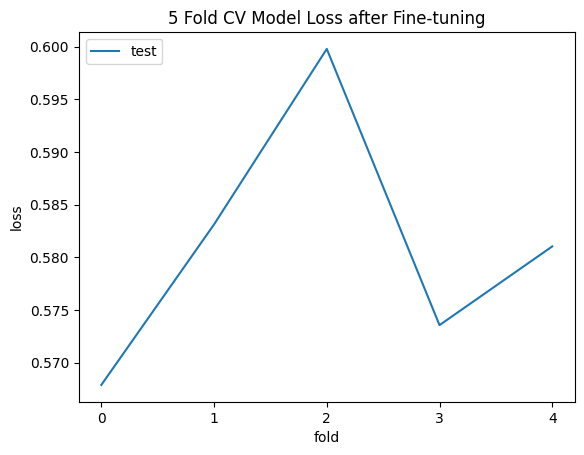

In [60]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(gender_acc)
plt.title('5 Fold CV Model Accuracy after Fine-tuning')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

plt.figure(2)
plt.plot(gender_loss)
plt.title('5 Fold CV Model Loss after Fine-tuning')
plt.ylabel('loss')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

In [33]:
# Load best model weights after fine-tuning
checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\tmp\\finetune\\finetune_best"
model.load_weights(checkpoint_path)

# Age

In [34]:
# Similar workflow to gender but with gender predictions used for age predictions
# https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

GRAYSCALE = True

age_model = ResNet50(
    include_top=False,
    weights=None, # Pretraining on CelebA
    input_tensor=None,
    pooling=None,
    classifier_activation="softmax"
)

gs_checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\ckpt\\gs_best"
age_model.load_weights(gs_checkpoint_path)

In [35]:
GENDER = False
age_ds_train, age_ds_val, age_ds_fulltrain, age_ds_test = adience_ds(age_train, age_val, age_fulltrain, age_test)

GRAYSCALE = True
age_ds_fulltrain = age_ds_fulltrain.map(read_image)
age_ds_fulltrain = prepare(age_ds_fulltrain, shuffle=True, augment=True)
age_ds_test = age_ds_test.map(read_image_valtest).batch(BATCH_SIZE)

In [36]:
image_batch, label_batch = next(iter(age_ds_fulltrain))
feature_batch = age_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 2048)


In [37]:
age_model.trainable = False
age_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [39]:
# Concatenate the inputs
concat_layer = tf.keras.layers.Concatenate()
concat_batch = concat_layer([model.output, feature_batch_average]) # model.output is the gender predictions
print(concat_batch.shape)

(64, 2050)


In [40]:
prediction_layer = tf.keras.layers.Dense(AGE_CLASSES, activation="softmax")
prediction_batch = prediction_layer(concat_batch)
print(prediction_batch.shape)

(64, 8)


In [41]:
# https://stackoverflow.com/questions/66653357/error-overlapping-layer-name-when-loading-a-keras-model
# ValueError: The name "resnet50" is used 2 times in the model. All layer names should be unique.
age_model._name = 'celeba_pretrained'
age_model.summary()

Model: "celeba_pretrained"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [62]:
# https://machinelearningmastery.com/keras-functional-api-deep-learning/
x = age_model(model.input, training=False)
x = global_average_layer(x)
combine = tf.keras.layers.Concatenate()([model.output,x])
x = tf.keras.layers.Dropout(0.2)(combine)
outputs = tf.keras.layers.Dense(AGE_CLASSES, activation="softmax")(x)
new_model = tf.keras.Model(inputs=[model.input], outputs=outputs)

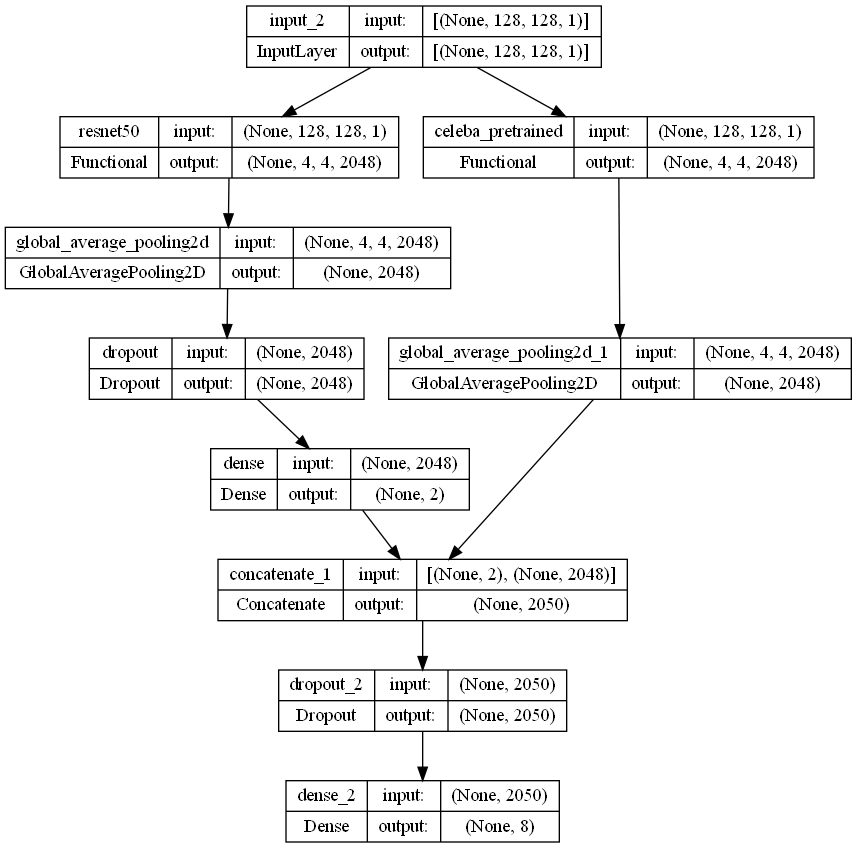

In [63]:
# Visualize our connectivity graph
# `rankdir='LR'` is to make the graph horizontal.
from keras.utils.vis_utils import plot_model
plot_model(new_model, show_shapes=True, rankdir="HR")

In [44]:
model.trainable = False # Freeze gender model
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23581440    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

In [45]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), 
    loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
# 5 fold cross validation
# Feature Extraction
GENDER = False
GRAYSCALE = True

checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\age_featext\\featext_best"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max',
                              save_freq='epoch',
                              verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

age_loss = []
age_acc = []
for i in fold_list:
    
    train, val, fulltrain, test = load_data(i)
    ds_train, ds_val, ds_fulltrain, ds_test = adience_ds(train, val, fulltrain, test)
    
    ds_fulltrain = ds_fulltrain.map(read_image)
    ds_fulltrain = prepare(ds_fulltrain, shuffle=True, augment=True)
    ds_test = ds_test.map(read_image_valtest).batch(BATCH_SIZE)
    
    history = new_model.fit(ds_fulltrain,
                    validation_data=ds_test,
                    epochs=20,
                    callbacks=[earlystop, cp_callback],
    )
    
    # https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
    filename = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\history\\age_featext_{}".format(i)
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    result = new_model.evaluate(ds_test)
    age_loss.append(result[0])
    age_acc.append(result[1])

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 1.9669 - accuracy: 0.2561
Epoch 1: val_accuracy improved from -inf to 0.40918, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\newtmp\age_featext\featext_best
205/205 [==============================] - 918s 4s/step - loss: 1.9669 - accuracy: 0.2561 - val_loss: 1.7874 - val_accuracy: 0.4092
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 1.9482 - accuracy: 0.2621
Epoch 2: val_accuracy improved from 0.40918 to 0.42285, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\newtmp\age_featext\featext_best
205/205 [==============================] - 918s 4s/step - loss: 1.9482 - accuracy: 0.2621 - val_loss: 1.7817 - val_accuracy: 0.4228
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 1.9345 - accuracy: 0.2701
Epoch 3: val_accuracy did not improve from 0.42285
205/205 [===========================

224/224 [==============================] - ETA: 0s - loss: 1.8228 - accuracy: 0.3448
Epoch 9: val_accuracy did not improve from 0.46061
49/49 [==============================] - 155s 3s/step - loss: 1.9751 - accuracy: 0.2348
Epoch 1/20
221/221 [==============================] - ETA: 0s - loss: 1.8456 - accuracy: 0.3219
Epoch 1: val_accuracy did not improve from 0.46061
221/221 [==============================] - 900s 4s/step - loss: 1.8456 - accuracy: 0.3219 - val_loss: 1.7994 - val_accuracy: 0.3330
Epoch 2/20
221/221 [==============================] - ETA: 0s - loss: 1.8529 - accuracy: 0.3213
Epoch 2: val_accuracy did not improve from 0.46061
221/221 [==============================] - 913s 4s/step - loss: 1.8529 - accuracy: 0.3213 - val_loss: 1.7867 - val_accuracy: 0.3288
Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 1.8458 - accuracy: 0.3222
Epoch 3: val_accuracy did not improve from 0.46061
221/221 [==============================] - 907s 4s/step - loss: 1.8458 

In [47]:
print("Accuracy for each fold:", age_acc)
print("Loss for each fold:", age_loss)

Accuracy for each fold: [0.4606116712093353, 0.2347629815340042, 0.33303382992744446, 0.30789914727211, 0.3533712327480316]
Loss for each fold: [1.71977698802948, 1.975106120109558, 1.79935884475708, 1.9407891035079956, 1.8097529411315918]


In [48]:
print("Average accuracy across 5 folds:", sum(age_acc) / len(age_acc))
print("Average loss across 5 folds:", sum(age_loss) / len(age_loss))

Average accuracy across 5 folds: 0.33793577253818513
Average loss across 5 folds: 1.8489567995071412


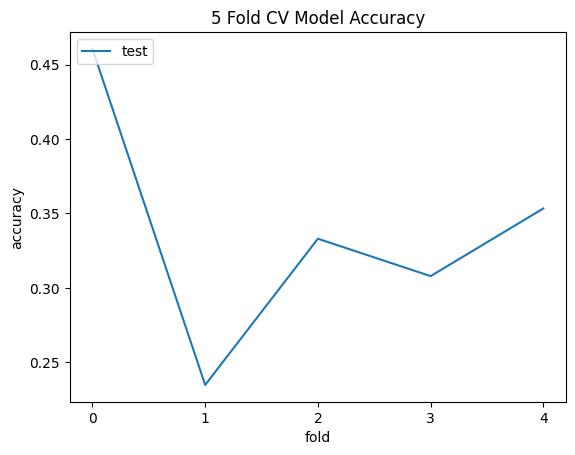

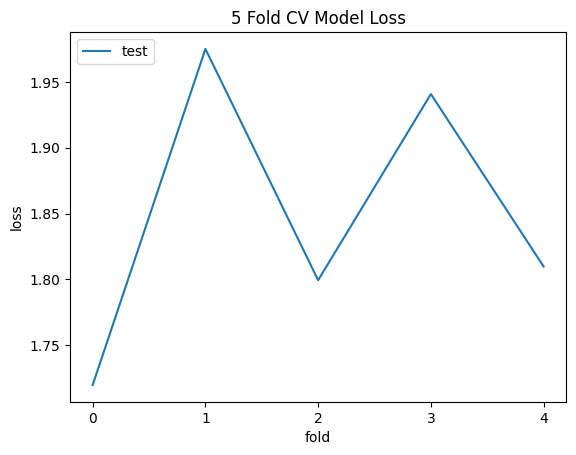

In [49]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(age_acc)
plt.title('5 Fold CV Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

plt.figure(2)
plt.plot(age_loss)
plt.title('5 Fold CV Model Loss')
plt.ylabel('loss')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

In [50]:
# Fine-tuning

# Load best model weights from feature extraction
checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\age_featext\\featext_best"
new_model.load_weights(checkpoint_path)

In [51]:
new_model.trainable = True
model.trainable = False
age_model.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the pretrained model: ", len(age_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in age_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the pretrained model:  175


In [53]:
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23581440    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

In [54]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), 
    loss="categorical_crossentropy", metrics=["accuracy"])

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 4, 4, 2048)   23581440    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

In [55]:
# 5 fold cross validation
# Fine-tuning
GENDER = False
GRAYSCALE = True

checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\age_finetune\\finetune_best"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor='val_accuracy',
                              mode='max',
                              save_freq='epoch',
                              verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

age_loss = []
age_acc = []
for i in fold_list:
    
    train, val, fulltrain, test = load_data(i)
    ds_train, ds_val, ds_fulltrain, ds_test = adience_ds(train, val, fulltrain, test)
    
    ds_fulltrain = ds_fulltrain.map(read_image)
    ds_fulltrain = prepare(ds_fulltrain, shuffle=True, augment=True)
    ds_test = ds_test.map(read_image_valtest).batch(BATCH_SIZE)
    
    history = new_model.fit(ds_fulltrain,
                    validation_data=ds_test,
                    epochs=20,
                    callbacks=[earlystop, cp_callback],
    )
    
    # https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
    filename = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\history\\age_finetune_{}".format(i)
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    result = new_model.evaluate(ds_test)
    age_loss.append(result[0])
    age_acc.append(result[1])

Epoch 1/20
205/205 [==============================] - ETA: 0s - loss: 1.8841 - accuracy: 0.2902
Epoch 1: val_accuracy improved from -inf to 0.47475, saving model to C:\Users\zhouw\OneDrive - Nanyang Technological University\NTU\CZ4042\Project\newtmp\age_finetune\finetune_best
205/205 [==============================] - 1326s 6s/step - loss: 1.8841 - accuracy: 0.2902 - val_loss: 1.6871 - val_accuracy: 0.4747
Epoch 2/20
205/205 [==============================] - ETA: 0s - loss: 1.8598 - accuracy: 0.2992
Epoch 2: val_accuracy did not improve from 0.47475
205/205 [==============================] - 1198s 6s/step - loss: 1.8598 - accuracy: 0.2992 - val_loss: 1.6518 - val_accuracy: 0.4747
Epoch 3/20
205/205 [==============================] - ETA: 0s - loss: 1.8433 - accuracy: 0.3030
Epoch 3: val_accuracy did not improve from 0.47475
205/205 [==============================] - 1228s 6s/step - loss: 1.8433 - accuracy: 0.3030 - val_loss: 1.6568 - val_accuracy: 0.4745
Epoch 4/20
205/205 [==========

221/221 [==============================] - ETA: 0s - loss: 1.6322 - accuracy: 0.3913
Epoch 2: val_accuracy did not improve from 0.50695
221/221 [==============================] - 1196s 5s/step - loss: 1.6322 - accuracy: 0.3913 - val_loss: 1.5842 - val_accuracy: 0.4157
Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 1.6261 - accuracy: 0.3937
Epoch 3: val_accuracy did not improve from 0.50695
221/221 [==============================] - 1176s 5s/step - loss: 1.6261 - accuracy: 0.3937 - val_loss: 1.5875 - val_accuracy: 0.4184
Epoch 4/20
221/221 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.4005
Epoch 4: val_accuracy did not improve from 0.50695
221/221 [==============================] - 1175s 5s/step - loss: 1.6140 - accuracy: 0.4005 - val_loss: 1.5956 - val_accuracy: 0.4196
Epoch 5/20
221/221 [==============================] - ETA: 0s - loss: 1.6170 - accuracy: 0.4008
Epoch 5: val_accuracy did not improve from 0.50695
221/221 [===============

In [56]:
print("Accuracy for each fold after fine-tuning:", age_acc)
print("Loss for each fold after fine-tuning:", age_loss)

Accuracy for each fold after fine-tuning: [0.506950855255127, 0.2753950357437134, 0.4195866882801056, 0.3623529374599457, 0.42160844802856445]
Loss for each fold after fine-tuning: [1.5096722841262817, 1.7818922996520996, 1.5955511331558228, 1.5999325513839722, 1.5795912742614746]


In [57]:
print("Average accuracy across 5 folds after fine-tuning:", sum(age_acc) / len(age_acc))
print("Average loss across 5 folds after fine-tuning:", sum(age_loss) / len(age_loss))

Average accuracy across 5 folds after fine-tuning: 0.39717879295349123
Average loss across 5 folds after fine-tuning: 1.6133279085159302


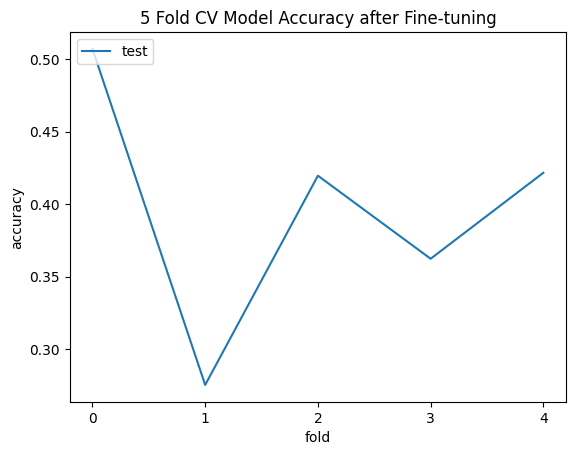

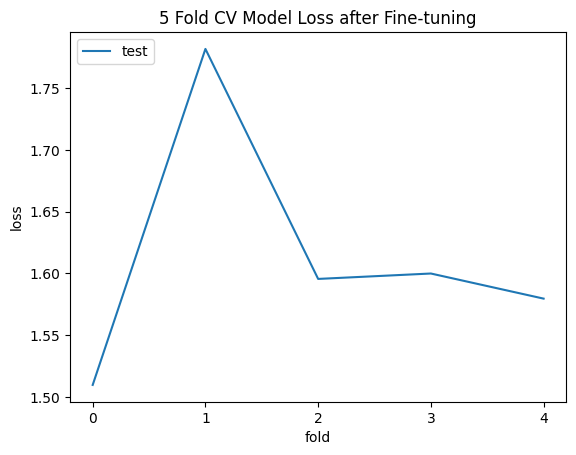

In [58]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(age_acc)
plt.title('5 Fold CV Model Accuracy after Fine-tuning')
plt.ylabel('accuracy')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

plt.figure(2)
plt.plot(age_loss)
plt.title('5 Fold CV Model Loss after Fine-tuning')
plt.ylabel('loss')
plt.xlabel('fold')
plt.xticks(fold_list)
plt.legend(['test'], loc='upper left')

In [74]:
# Load best model weights after fine-tuning
checkpoint_path = "C:\\Users\\zhouw\\OneDrive - Nanyang Technological University\\NTU\\CZ4042\\Project\\newtmp\\age_finetune\\finetune_best"
new_model.load_weights(checkpoint_path)